# Appendix

## Data Extraction and Feature Extraction

In [ ]:
#HARI

import json
from tqdm import tqdm
import pandas as pd
import utility
import os

# Define the path to the folder
path = 'eeg_data_test/'

eeg_data_control = []
eeg_data_alcoholic = []

# Loop through the folder
for folder in os.listdir(path):
    if os.path.isdir(path + folder):
        for file in os.listdir(path + folder + '/'):
            with open(path + folder + '/' + file, 'r') as f:
                eeg_data_point = []
                for line in f:
                    # Split each line by whitespace
                    values = line.strip().split()
                    # Check if the line contains data
                    if line[0] != '#':
                        # Append the values to the data list
                        eeg_data_point.append([values[0], values[1], int(
                            values[2]), float(values[3])])
            if folder[3] == 'c':
                eeg_data_control.append(eeg_data_point)
            elif folder[3] == 'a':
                eeg_data_alcoholic.append(eeg_data_point)


sensor_list = [
    "FP1", "FP2", "F7", "F8", "AF1", "AF2", "FZ", "F4", "F3", "FC6", "FC5", "FC2", "FC1", "T8", "T7", "CZ", "C3", "C4", "CP5", "CP6", "CP1", "CP2", "P3", "P4", "PZ", "P8", "P7", "PO2", "PO1", "O2", "O1", "X", "AF7", "AF8", "F5", "F6", "FT7", "FT8", "FPZ", "FC4", "FC3", "C6", "C5", "F2", "F1", "TP8", "TP7", "AFZ", "CP3", "CP4", "P5", "P6", "C1", "C2", "PO7", "PO8", "FCZ", "POZ", "OZ", "P2", "P1", "CPZ", "Y"
]

sensor_dict = {}

for sensor in sensor_list:
    sensor_dict[sensor] = {
        "control": [],
        "alcoholic": []
    }

for control_data, alcoholic_data in tqdm(zip(eeg_data_control, eeg_data_alcoholic), total=len(eeg_data_control), desc="Processing data", unit="data"):
    for sensor in tqdm(sensor_list, desc="Processing sensors", unit="sensor", leave=False):

        control_sensor_data = utility.get_sensor_values(control_data, sensor)
        alcoholic_sensor_data = utility.get_sensor_values(
            alcoholic_data, sensor)

        G_control = utility.visibility_graph(control_sensor_data)
        G_alcoholic = utility.visibility_graph(alcoholic_sensor_data)

        sensor_dict[sensor]["control"].append(utility.features(G_control))
        sensor_dict[sensor]["alcoholic"].append(utility.features(G_alcoholic))

# Define the file path
file_path = "sensor_data_test.json"

# Write sensor_dict to a JSON file
with open(file_path, "w") as file:
    json.dump(sensor_dict, file)

In [ ]:
import math
import networkx as nx
import itertools
import numpy as np
import pyts
import ts2vg

#SIRI

def my_visibility_graph(time_series):
    """
    Function to create visibility graph from time series data
    :param time_series: list of time series data
    :return: networkx graph object
    """
    G = nx.Graph()
    n = len(time_series)

    for (t1, n1), (t2, n2) in itertools.combinations(enumerate(time_series), 2):
        slope = (n2 - n1) / (t2 - t1)
        y_intercept = n2 - slope * t2

        obstructed = any(
            n >= slope * t1 + y_intercept
            for t, n in enumerate(time_series[t1 + 1:t2], start=t1 + 1)
        )

        if not obstructed:
            G.add_edge(t1, t2)

    return G


def my_reccurance_graph(time_series, threshold):
    """
    Function to create reccurance graph from time series data
    :param time_series: list of time series data
    :param threshold: threshold value for reccurance
    :return: networkx graph object
    """
    G = nx.Graph()
    n = len(time_series)
    for i in range(n):
        for j in range(i+1, n):
            if abs(time_series[j] - time_series[i]) <= threshold:
                G.add_edge(i, j)
    return G


def reccurance_graph(time_series, threshold):
    rp = pyts.image.RecurrencePlot(threshold=threshold)
    X_rp = rp.fit_transform([time_series])
    X_rp = X_rp[0]
    X_rp -= np.eye(X_rp.shape[0])
    G = nx.from_numpy_array(X_rp)


vg = ts2vg.NaturalVG()
def visibility_graph(time_series, vg=vg):
    vg.build(time_series)
    G = vg.as_networkx()
    return G


# HARI

def get_sensor_values(data, sensor_name):
    sensor_values = []
    for row in data:
        if row[1] == sensor_name:
            sensor_values.append(row[3])
    return sensor_values


def GraphIndexComplexity(G):
    lamda_max = max(np.linalg.eig(nx.to_numpy_array(G))[0])
    n = G.number_of_nodes()

    c = (lamda_max - 2 * np.cos(np.pi/(n + 1))) / \
        (n - 1 - np.cos(np.pi/(n + 1)))
    C = 4 * c * (1 - c)

    return C


def VertexColoringNumber(G):
    greedy_color = nx.coloring.greedy_color(G)
    return len(set(greedy_color.values()))


def degree_distribution(G):
    vk = dict(G.degree())
    vk = list(vk.values())  # We get only the degree values
    maxk = np.max(vk)
    kvalues = np.arange(0, maxk + 1)  # Possible values of k
    Pk = np.zeros(maxk + 1)  # P(k)
    for k in vk:
        Pk[k] += 1
    Pk = Pk / sum(Pk)  # The sum of the elements of P(k) must be equal to one

    return kvalues, Pk


def shannon_entropy(G):
    k, Pk = degree_distribution(G)
    H = 0
    for p in Pk:
        if p > 0:
            H -= p * math.log(p, 2)
    return H


def features(G):


    clustering_coeff = nx.average_clustering(G)

    # Centrality measures
    degree_centrality = np.mean(
        list(nx.degree_centrality(G).values()))
    betweenness_centrality = np.mean(
        list(nx.betweenness_centrality(G).values()))
    closeness_centrality = np.mean(
        list(nx.closeness_centrality(G).values()))
    pagerank = np.mean(list(nx.pagerank(G).values()))

    # Other Graph properties
    degree_distribution = np.mean(
        np.array(nx.degree_histogram(G)))
    average_path_length = nx.average_shortest_path_length(G)
    assortativity = nx.degree_assortativity_coefficient(G)
    # Updated to compute diameter
    longest_path = nx.diameter(G)

    no_of_edges = nx.number_of_edges(G)

    clustering_coeff = nx.average_clustering(G)

    global_efficiency = nx.global_efficiency(G)

    graph_index_complexity = np.abs(GraphIndexComplexity(G))

    max_clique_size = len(next(nx.find_cliques(G)))  # size of max clique

    min_cut_size = len(nx.minimum_edge_cut(G))  # size of minimum cut

    vertex_coloring_number = VertexColoringNumber(G)

    entropy = shannon_entropy(G)

    return (
        degree_centrality,
        betweenness_centrality,
        closeness_centrality,
        pagerank,
        degree_distribution,
        average_path_length,
        assortativity,
        longest_path,
        no_of_edges,
        clustering_coeff,
        global_efficiency,
        graph_index_complexity,
        max_clique_size,
        min_cut_size,
        vertex_coloring_number,
        entropy
    )

## Feature Analysis/Preprocessing

In [ ]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [ ]:
with open('sensor_data.json') as file:
    data = json.load(file)

sensor_data = dict(data)

# Create an empty list to store the data
data_list = []

# Iterate over the sensor_data dictionary
for sensor, classes in sensor_data.items():
    for class_name, trials in classes.items():
        for trial in trials:
            # Append the trial data along with the sensor and class name
            data_list.append(trial + [sensor, class_name])

# Convert the list to a NumPy array
data_array = np.array(data_list)

features = [
    'degree_centrality',
    'betweenness_centrality',
    'closeness_centrality',
    'pagerank',
    'degree_distribution',
    'average_path_length',
    'assortativity',
    'longest_path',
    'no_of_edges',
    'clustering_coeff',
    'global_efficiency',
    'graph_index_complexity',
    'max_clique_size',
    'min_cut_size',
    'vertex_coloring_number',
    'entropy'
]

#HARI

def get_sensor_data(sensor):
    sensor_name = sensor 
    sensor_mask = data_array[:, -2] == sensor_name
    selected_data = np.array(data_array[sensor_mask, :-2].astype(float))
    selected_class = np.array(data_array[sensor_mask, -1].astype(str))
    
    reshaped_class = selected_class.reshape(-1, 1)

    df = pd.DataFrame(np.concatenate(
        (selected_data, reshaped_class), axis=1), columns=features + ["Class"])
    df[df.columns[:-1]] = df[df.columns[:-1]].astype(float)
    
    return (df)

In [ ]:
sensor_list = [
    "FP1", "FP2", "F7", "F8", "AF1", "AF2", "FZ", "F4", "F3", "FC6", "FC5", "FC2", "FC1", "T8", "T7", "CZ", "C3", "C4", "CP5", "CP6", "CP1", "CP2", "P3", "P4", "PZ", "P8", "P7", "PO2", "PO1", "O2", "O1", "X", "AF7", "AF8", "F5", "F6", "FT7", "FT8", "FPZ", "FC4", "FC3", "C6", "C5", "F2", "F1", "TP8", "TP7", "AFZ", "CP3", "CP4", "P5", "P6", "C1", "C2", "PO7", "PO8", "FCZ", "POZ", "OZ", "P2", "P1", "CPZ", "Y"
]

df = get_sensor_data("FP1")
df

degree_centrality  betweenness_centrality  closeness_centrality  \
0             0.044210                0.010553              0.280446   
1             0.039982                0.010012              0.289079   
2             0.037531                0.011464              0.265197   
3             0.104075                0.006009              0.409571   
4             0.080147                0.008731              0.333464   
..                 ...                     ...                   ...   
595           0.056679                0.009884              0.294259   
596           0.110478                0.005919              0.417091   
597           0.044424                0.008892              0.315155   
598           0.044700                0.010430              0.282633   
599           0.047426                0.009630              0.298006   

     pagerank  degree_distribution  average_path_length  assortativity  \
0    0.003906             6.736842             3.680576       0.325012   
1    0.003906             5.688889             3.543015       0.241595   
2    0.003906             6.736842             3.911734       0.360248   
3    0.003906             2.098361             2.526256      -0.203977   
4    0.003906             2.206897             3.217616      -0.155807   
..        ...                  ...                  ...            ...   
595  0.003906             4.063492             3.510539       0.193148   
596  0.003906             1.841727             2.503370      -0.257679   
597  0.003906             4.338983             3.258548       0.233547   
598  0.003906             5.565217             3.649265       0.260178   
599  0.003906             5.224490             3.446017       0.179843   

     longest_path  no_of_edges  clustering_coeff  global_efficiency  \
0             8.0       1443.0          0.703904           0.320628   
1             8.0       1305.0          0.704758           0.325196   
2            10.0       1225.0          0.690865           0.304321   
3             5.0       3397.0          0.606480           0.456944   
4            11.0       2616.0          0.659481           0.395926   
..            ...          ...               ...                ...   
595           8.0       1850.0          0.662535           0.343678   
596           7.0       3606.0          0.587812           0.465858   
597           7.0       1450.0          0.683003           0.350928   
598           8.0       1459.0          0.691099           0.324122   
599           7.0       1548.0          0.692909           0.338674   

     graph_index_complexity  max_clique_size  min_cut_size  \
0                  0.238466              4.0           2.0   
1                  0.228623              4.0           1.0   
2                  0.215485              4.0           1.0   
3                  0.597629              7.0           4.0   
4                  0.540860              5.0           1.0   
..                      ...              ...           ...   
595                0.342488              2.0           1.0   
596                0.645841              4.0           1.0   
597                0.261838              2.0           1.0   
598                0.244417              6.0           2.0   
599                0.261712              5.0           1.0   

     vertex_coloring_number   entropy      Class  
0                      10.0  4.199593    control  
1                       9.0  4.038818    control  
2                       9.0  3.974052    control  
3                      16.0  5.540757    control  
4                      14.0  5.042792    control  
..                      ...       ...        ...  
595                    11.0  4.741034  alcoholic  
596                    14.0  5.647066  alcoholic  
597                    10.0  4.274832  alcoholic  
598                    10.0  4.289715  alcoholic  
599                    10.0  4.460486  alcoholic  

[600 rows x 17 columns]

In [ ]:
#PRANAV

def normalize(df):
    scaler = MinMaxScaler()
    columns_to_normalize = df.columns[:-1]
    df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])
    return df

df_normalized = normalize(df)
df_normalized

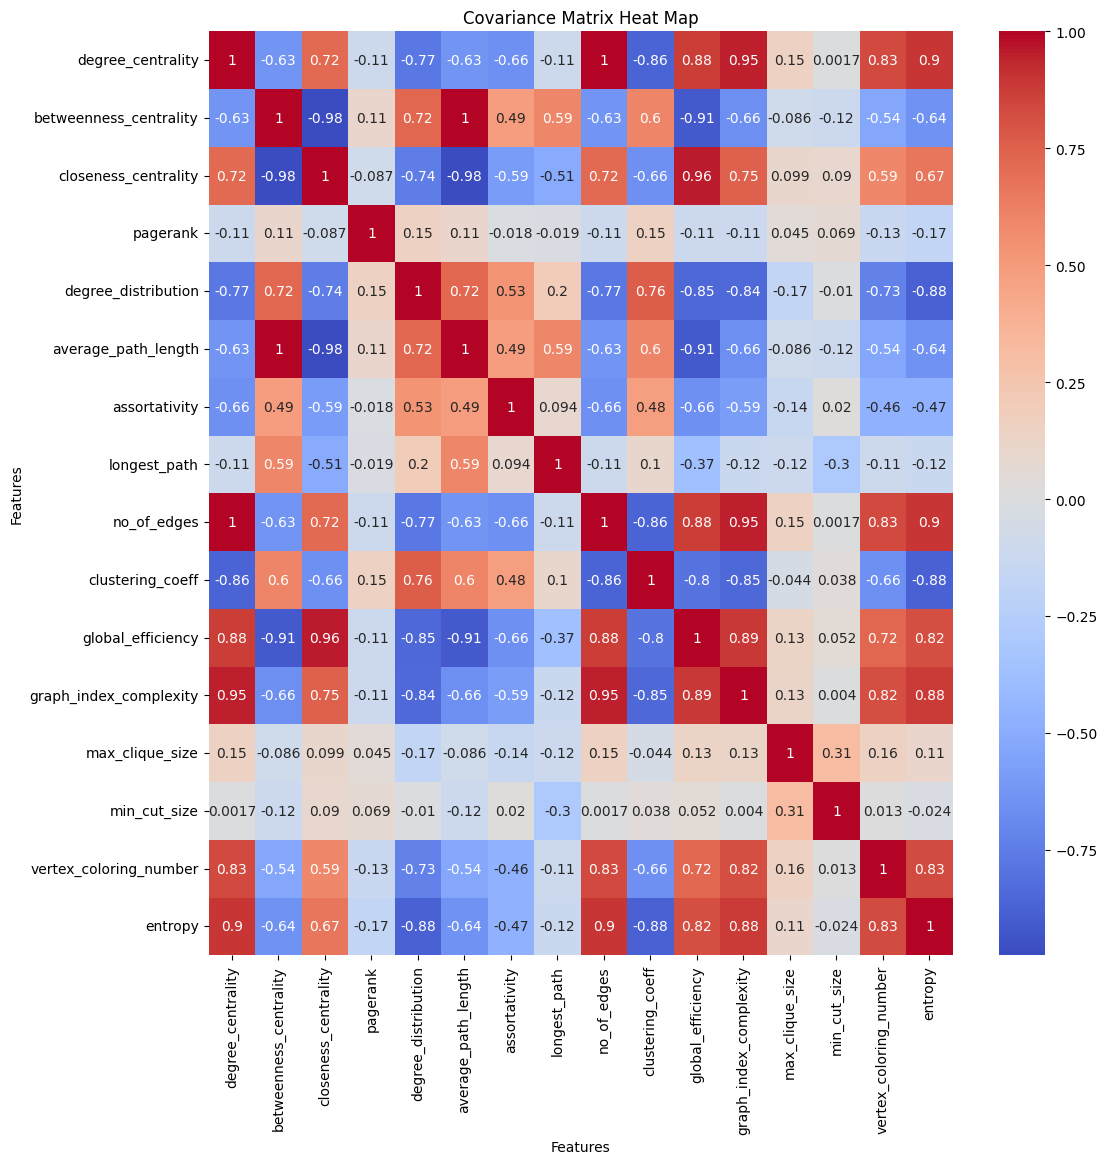

In [ ]:
#PRANAV

cov_matrix = np.corrcoef(np.array(df_normalized[df.columns[:-1]]), rowvar=False)

fig, ax = plt.subplots(figsize=(12, 12))

sns.heatmap(cov_matrix, annot=True, cmap='coolwarm', ax=ax,
            xticklabels=features, yticklabels=features)

ax.set_title('Covariance Matrix Heat Map')
ax.set_xlabel('Features')
ax.set_ylabel('Features')

plt.show()

<AxesSubplot: >

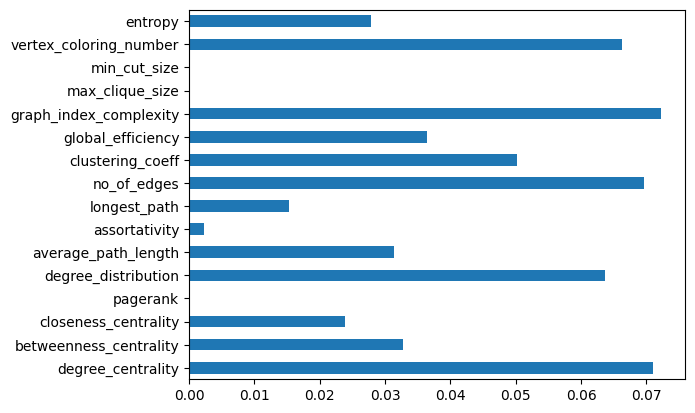

In [ ]:
#PRANAV

from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
import pandas as pd

importances = mutual_info_classif(df_normalized[df.columns[:-1]], df_normalized[df.columns[-1]])
feat_importances = pd.Series(importances, index=features)
feat_importances.plot(kind='barh')

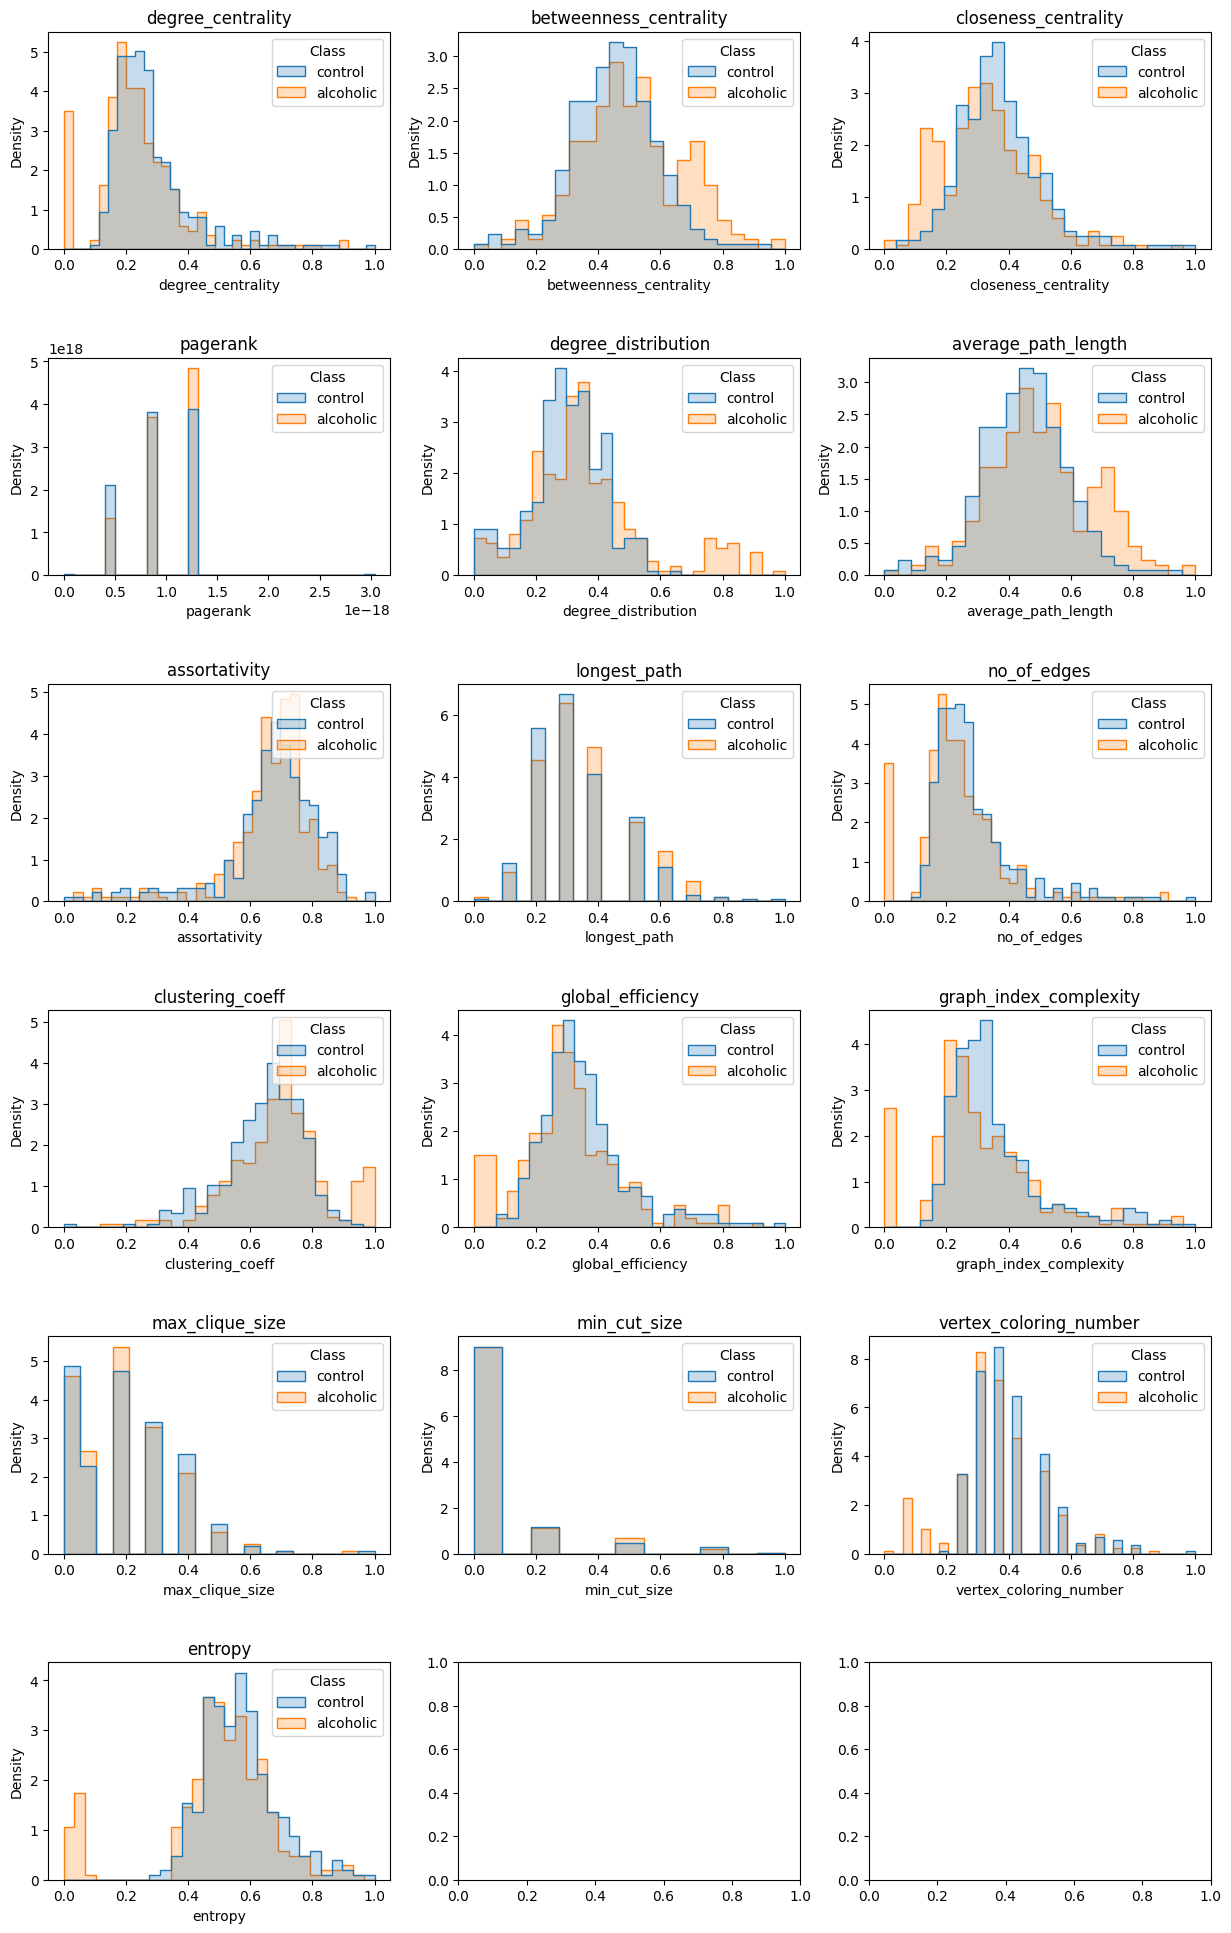

In [ ]:
#PRANAV

nrows = (len(df.columns) - 1) // 3 + 1  # Number of rows in the grid
ncols = 3  # Number of columns in the grid
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 4 * nrows))

# Flatten the axes array
axes = axes.flatten()

# Loop through the columns and plot histograms
for i, col in enumerate(df_normalized.columns[:-1]):  # Exclude the last column ('Class')
    ax = axes[i]
    sns.histplot(data=df, x=col, hue="Class", element="step",
                 stat="density", common_norm=False, ax=ax)
    ax.set_title(col)

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.5)

# Show the plot
plt.show()

## Sensor Selection

In [ ]:
#PRANAV

nrows = 32  # Number of rows in the grid (adjust based on sensor_list length)
ncols = 2  # Number of columns in the grid
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 4 * nrows))

# Flatten the axes array
axes = axes.flatten()

for i, sensor in enumerate(sensor_list):
    ax = axes[i]
    df = normalize(get_sensor_data(sensor))

    # Group by 'Class' and calculate the mean of each feature
    data = df.groupby('Class').mean().reset_index()

    # Plotting the data
    melted_data = data.melt(
        id_vars='Class', var_name='Feature', value_name='Value')
    sns.lineplot(data=melted_data, x='Feature', y='Value', hue='Class', ax=ax)

    ax.set_title(sensor)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# Adjust spacing between subplots
plt.subplots_adjust(hspace=1)

# Show the plot
plt.show()

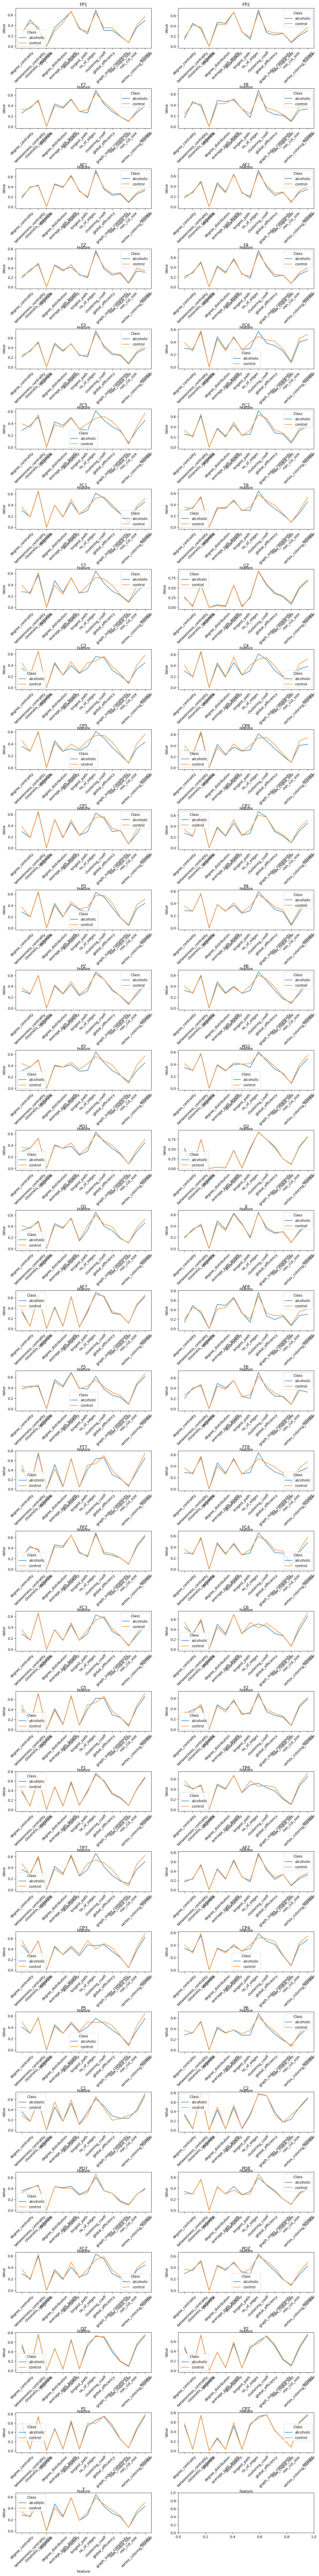

### Best Channels
1. FCZ
2. PO8
3. TP7
4. FC5
5. CP3

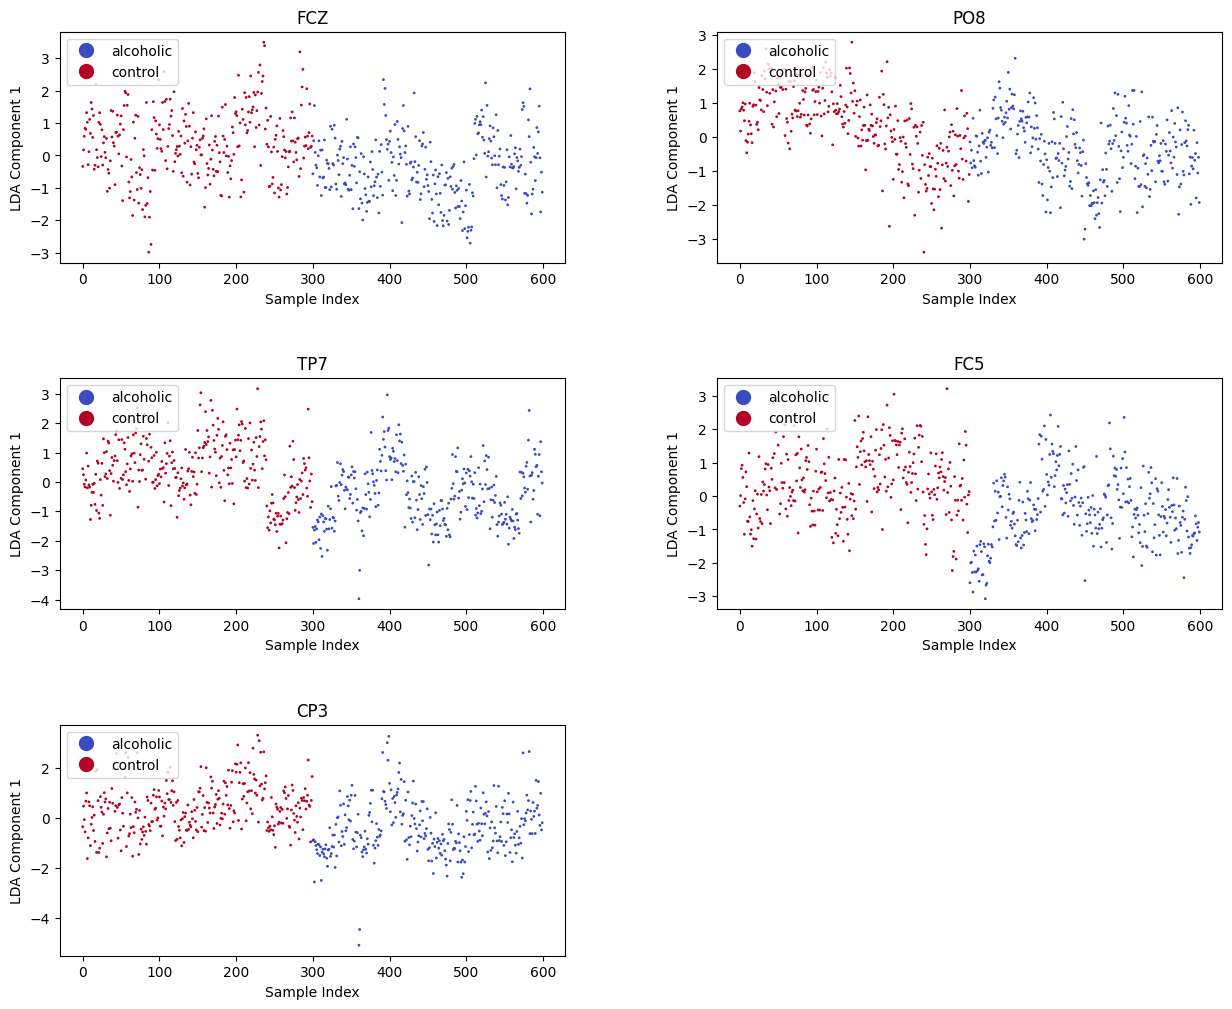

In [ ]:
#GANESH

selected_sensors = ["FCZ", "PO8", "TP7", "FC5", "CP3"]

lda = LinearDiscriminantAnalysis(n_components=1)
total_lda_data = np.zeros((len(selected_sensors), 600))

nrows = 3  # Number of rows in the grid
ncols = 2  # Number of columns in the grid
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 4 * nrows))

axes = axes.flatten()

for i, sensor in enumerate(selected_sensors):
    data = normalize(get_sensor_data(sensor))
    lda_data = lda.fit_transform(
        data[data.columns[:-1]], data[data.columns[-1]])
    
    total_lda_data[i,:] = np.array(lda_data, dtype=float).reshape(-1)
    unique_classes = np.unique(data["Class"])
    colors = plt.cm.coolwarm(np.linspace(0, 1, len(unique_classes)))

    # Map class labels to colors
    color_map = dict(zip(unique_classes, colors))
    point_colors = [color_map[label] for label in data["Class"]]

    ax = axes[i]
    ax.scatter(range(len(lda_data)), lda_data[:, 0], c=point_colors, s=1)

    # Add titles and labels
    ax.set_title(sensor)
    ax.set_xlabel('Sample Index')
    ax.set_ylabel('LDA Component 1')
    
    legend_elements = [plt.Line2D([0], [0], marker='o', color=color, label=label, markersize=10, linestyle='') for label, color in color_map.items()]
    ax.legend(handles=legend_elements, loc='upper left')

# Hide any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

lda_df = pd.DataFrame(total_lda_data.T, columns=selected_sensors)
lda_df['Class'] = data['Class']

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.5, wspace=0.3)

# Show the plot
plt.show()

In [ ]:
#GANESH

def lda_process_data(selected_sensors):
    lda = LinearDiscriminantAnalysis(n_components=1)
    total_lda_data = np.zeros((len(selected_sensors), 600))

    for i, sensor in enumerate(selected_sensors):
        data = normalize(get_sensor_data(sensor))
        lda_data = lda.fit_transform(data[data.columns[:-1]], data[data.columns[-1]])
        total_lda_data[i, :] = np.array(lda_data, dtype=float).reshape(-1)

    lda_df = pd.DataFrame(total_lda_data.T, columns=selected_sensors)
    lda_df['Class'] = data['Class']
    pd.DataFrame.to_csv(lda_df, 'lda_data_train.csv')

    return lda_df

selected_sensors = ["FCZ", "PO8", "TP7", "FC5", "CP3"]
processed_data = lda_process_data(selected_sensors)
print(processed_data)

          FCZ       PO8       TP7       FC5       CP3      Class
0   -0.339519  0.761064  0.448952 -0.299613 -0.359410    control
1    0.168773  0.169298  0.245315  0.013848  0.463892    control
2    0.589155  0.818918 -0.077216  0.822823 -0.075972    control
3    0.835435  0.876217 -0.169135  0.925316 -0.563021    control
4    0.803042  0.998513  0.067937  0.561219  0.662942    control
..        ...       ...       ...       ...       ...        ...
595  1.516908 -1.791880  0.933004 -0.830768  0.110309  alcoholic
596 -0.075323 -0.171529 -1.147749 -1.328829 -0.303811  alcoholic
597 -1.741462 -1.059696  1.366860 -0.932320  0.972767  alcoholic
598 -0.517063 -0.598727  0.345535 -0.788825 -0.485807  alcoholic
599 -1.134498 -1.926815 -0.035415 -1.074343 -0.198042  alcoholic

[600 rows x 6 columns]


## Classification

### Graph Features

In [ ]:
#GANESH

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

In [ ]:
def get_data(path):
    with open (path, 'r'):
        df = pd.read_csv(path)
    df.drop(['Unnamed: 0'], axis=1, inplace=True)
    return df

In [ ]:
data_train = get_data("lda_data_train.csv")
data_test = get_data("lda_data_test.csv")

X_train = data_train.drop(['Class'], axis=1)
Y_train = data_train['Class']
X_test = data_test.drop(['Class'], axis=1)
Y_test = data_test['Class']

#### SVM

In [ ]:
model = svm.SVC(kernel='linear')

model.fit((X_train), Y_train)
Y_pred = model.predict(X_test)

print(accuracy_score(Y_test, Y_pred))

0.8


#### KNN

In [ ]:
model = KNeighborsClassifier(n_neighbors = 22)
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)

print(accuracy_score(Y_test, Y_pred))

0.7966666666666666


#### Random Forest

In [ ]:
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)

print(accuracy_score(Y_test, Y_pred))

0.7766666666666666


#### Logistic Regression

In [ ]:
model = LogisticRegression(random_state=64)
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)

print(accuracy_score(Y_test, Y_pred))

0.7933333333333333


#### Naive Bayes

In [ ]:
model = GaussianNB()
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)

print(accuracy_score(Y_test, Y_pred))

0.7716666666666666


### Statisical Features

In [ ]:
import json
from tqdm import tqdm
import pandas as pd
import os
import numpy as np

# Define the path to the folder
path = 'eeg_data_test/'

eeg_data_control = []
eeg_data_alcoholic = []

# Loop through the folder
for folder in os.listdir(path):
    if os.path.isdir(path + folder):
        for file in os.listdir(path + folder + '/'):
            with open(path + folder + '/' + file, 'r') as f:
                eeg_data_point = []
                for line in f:
                    # Split each line by whitespace
                    values = line.strip().split()
                    # Check if the line contains data
                    if line[0] != '#':
                        # Append the values to the data list
                        eeg_data_point.append([values[0], values[1], int(
                            values[2]), float(values[3])])
            if folder[3] == 'c':
                eeg_data_control.append(eeg_data_point)
            elif folder[3] == 'a':
                eeg_data_alcoholic.append(eeg_data_point)
                
eeg_data_control = np.array(eeg_data_control)
eeg_data_alcoholic = np.array(eeg_data_alcoholic)

In [ ]:
#SIRI

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler


all_data = np.concatenate((eeg_data_control, eeg_data_alcoholic), axis=0)

# Define labels: 0 for control, 1 for alcoholic
labels = np.concatenate((np.zeros(len(eeg_data_control)), np.ones(len(eeg_data_alcoholic))))


features = []

# Extract features (mean, variance, skewness, kurtosis) for each data point
for data_point in tqdm(all_data):
    df = pd.DataFrame(data_point, columns=['Channel', 'Time', 'Epoch', 'Value'])
    df['Epoch'] = df['Epoch'].astype(int)
    df['Value'] = df['Value'].astype(float)
    # Extract features
    mean_val = df['Value'].mean()
    variance_val = df['Value'].var()
    skewness_val = df['Value'].skew()
    kurtosis_val = df['Value'].kurtosis()
    features.append([mean_val, variance_val, skewness_val, kurtosis_val])

# Convert features list to numpy array
features = np.array(features)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize classifiers
classifiers = {
    "SVM": SVC(kernel='linear'),
    "Random Forest": RandomForestClassifier(),
    "Logistic Regression": LogisticRegression(),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB()
}

# Train and evaluate classifiers
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    accuracy = accuracy_score(y_test, preds) * 100
    print(f"{name} Accuracy: {accuracy:.2f}%")
    print(f"{name} Classification Report:")
    print(classification_report(y_test, preds))

100%|████████████████████████████████████████| 600/600 [00:05<00:00, 113.26it/s]


SVM Accuracy: 67.50%
SVM Classification Report:
              precision    recall  f1-score   support

         0.0       0.69      0.66      0.68        62
         1.0       0.66      0.69      0.67        58

    accuracy                           0.68       120
   macro avg       0.68      0.68      0.67       120
weighted avg       0.68      0.68      0.68       120

Random Forest Accuracy: 70.83%
Random Forest Classification Report:
              precision    recall  f1-score   support

         0.0       0.71      0.73      0.72        62
         1.0       0.70      0.69      0.70        58

    accuracy                           0.71       120
   macro avg       0.71      0.71      0.71       120
weighted avg       0.71      0.71      0.71       120

Logistic Regression Accuracy: 62.50%
Logistic Regression Classification Report:
              precision    recall  f1-score   support

         0.0       0.62      0.71      0.66        62
         1.0       0.63      0.53      0.